In [1]:
from src.infer_models import infer
from src.preprocess import preprocess
from src.archs_models import *
# from src.opts_models import dectree
import os
import sys
import pathlib
from pathlib import Path

import numpy as np
from numpy.core.shape_base import block
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Computer Modern Sans Serif"],
    "text.latex.preamble": r'\usepackage{amsmath,amsthm,amsfonts,amssymb}',
    })  # Avant Garde, 

np.set_printoptions(precision=4)
np.set_printoptions(formatter={'float': "{:0.4f}".format})


# Ensure path is referenced to this script's root
# thisdir = os.path.dirname(__file__)
thisdir = Path.cwd()
# os.chdir(thisdir)
os.chdir(sys.path[0])
print(os.getcwd())

figs_dir = os.path.join(thisdir, 'figs/')
if not os.path.isdir(figs_dir):
    os.makedirs(figs_dir)

# os.chdir(r'./ai534ias/ia1/')

# Generate the path to the file relative to your python script:
# script_location = Path(__file__).absolute().parent
# print(script_location)
# file_location = script_location / 'file.yaml'
# file = file_location.open()


/home/somefunagba/ias/ia4


In [2]:
# Data Preprocessing

# do major feature engineering - 0 | 1
doengr = 0
donormalize = 1

# Train
rawdata = 'csvs/mushroom-train.csv'
traindata, train_id = preprocess(rawdata, donormalize=donormalize, istrain=1,
                                 traininfo=None, doengr=doengr)

# View final data entering the model.
# print(traindata['X'])

# Dev
rawdata = 'csvs/mushroom-val.csv'
devdata, dev_id = preprocess(rawdata, donormalize=donormalize, istrain=0,
                             traininfo=traindata, doengr=doengr)


data size (rows,columns) (4500, 118)
data size (rows,columns) (1600, 118)


In [3]:

# class cross entropy
def ent_class(y):
    uclass = np.unique(y)
    ent = 0
    for uy in uclass:
        # counts
        n_uy = np.sum(y == uy)
        p = n_uy/len(y)
        ent -= p*np.log2(p)

    return ent

# class gini


def gini_class(y):
    uclass = np.unique(y)
    gini = 1
    for uy in uclass:
        # counts
        n_uy = np.sum(y == uy)
        p = n_uy/len(y)
        gini -= (p)**2

    return gini


# Greedily search for best decision split on data by:
# iterating over every unique value in each feature in given data
# - uses information gain to decide
#
# Outputs: Best feature for split, with its id, name, val and ig
# Information Gain = ig
# Unique Value in Feature = val
# Column ID in data = id
# Column Name in data = name
def search_bestsplit(DX, DY, x_names, split_metric=ent_class):

    # class counts for given data - root
    y = DY
    ent_yroot = split_metric(y)

    # given rows of data
    root_rows = {'DX': DX, 'DY': y}
    y = root_rows['DY']
    infogains = []  # track best infogain in each x feature
    uvalx_gain = []  # track unique val w.r.t to best infogain in x feature

    for x in root_rows['DX'].T:

        # unique values in each column (feature) of the data
        unique_x = np.unique(x)

        # in: data, take each row of feature x,  its unique features ux
        # binary split of rows based on question on a feature
        # for rowx in x:

        # conditional entropy of y given this x column feature
        enty_c_x = 0
        # info gain on y given this x column feature
        infogain_x = 0
        ux_best = 0
        for ux in unique_x:
            # question: this unique value -> this feature
            qat = (x == ux)  # true parts # >=, <=
            qaf = ~(qat)    # false parts

            # skip this split quest
            # if either true parts or false parts is empty
            if len(qat)*len(qaf) == 0:
                continue

            # print(f"Is {x} == {ux}? {qat}")

            # full data split based on this unique value -> feature
            # leaf_trows = {'DX' : DX[qat], 'DY' : y[qat]}
            # leaf_frows = {'DX' : DX[qaf], 'DY' : y[qaf]}

            # counts: this unique value -> feature
            n_t = np.sum(qat)  # print(ux,n_t \equiv n_ux)
            # likelihood of the truth of unique value
            pxt = n_t/len(x)
            # corresponding class given the truth of this unique value
            y_uxt = y[qat]
            # condit. entropy of y given truth of this unique value -> feature
            ent_y_c_uxt = split_metric(y_uxt)

            # - altA start
            # enty_c_x +=  pxt*ent_y_c_uxt
            # - altA end

            # - altB start
            # corresponding class given the falsity of this unique value
            y_uxf = y[qaf]
            # condit. entropy of y given falsity of this unique value -> feature
            ent_y_c_uxf = split_metric(y_uxf)
            # condit. entropy of y given this unique value -> feature
            enty_c_ux = pxt*ent_y_c_uxt + (1-pxt)*ent_y_c_uxf
            # info gain on y given this this unique value in this x column/feature
            infogain_ux = ent_yroot - enty_c_ux
            if infogain_ux > infogain_x:
                infogain_x = infogain_ux
                ux_best = ux
            # - altB end

        # - altB start
        infogains.append(infogain_x)
        uvalx_gain.append(ux_best)
        # - altB end

        # - altA start
        # information gain for split on this column/feature
        # infogain_x = ent_yroot - enty_c_x
        # infogains.append(infogain_x)
        # - altA end

    # print(f"DX: {infogains}")
    infogain_best = np.amax(infogains)
    infogain_best_x_id = np.argmax(infogains)
    # - altB start
    x_name_best = x_names[infogain_best_x_id]
    uvalx_best = uvalx_gain[infogain_best_x_id]
    # - altB end

    # print("Information Gain: I.G")
    # - altA start
    # print(f"I.G (best split) : {infogain_best}, id: {infogain_best_x_id}, name: {x_names[infogain_best_x_id]}")
    # - altA end

    # - altB start
    # print(
    #     f"I.G (best split) : {infogain_best}, id: {infogain_best_x_id}, name: {x_name_best}, val: {uvalx_best}")
    # - altB end

    return {'name': x_name_best, 'id': infogain_best_x_id, 'val': uvalx_best, 'ig': infogain_best}


def max_class(y):
    n_uy = []
    uclass = np.unique(y)
    for uy in uclass:
        # counts
        n_uy.append(np.sum(y == uy))

    # decision theory:
    # return class/output that occurs most
    max_y = uclass[np.argmax(n_uy)]

    return max_y

# Terminal Node
# - holds predictions of a terminal leaf node
# - which classifies data


class Leaf:
    def __init__(self, data_x, data_y):
        self.predictions = max_class(data_y)


# Decision Node
# - asks a question and splits further into two nodes
class Node:
    def __init__(self, node_dec, branch_t, branch_f, depth):
        self.node_dec = node_dec
        self.branch_t = branch_t
        self.branch_f = branch_f
        self.depth = depth
        pass


# Builds Decision Tree
# - by recursion from main root till no more
def build_dectree(data_x, data_y, x_names, metric_class=ent_class, max_depth=np.Infinity,min_size=2, depth=1):

    # search over all features and 
    # split dataset based on unique feature with best (max) I.G
    best_splitdec = search_bestsplit(data_x, data_y, x_names, metric_class).copy()

    # base case: 
    # if no further information gain, or
    # max. depth of tree or 
    # min. size of samples is reached, then TERMINATE TREE growth
    # return a Leaf which:
    # predict the class with the most occurence
    if (best_splitdec['ig'] == 0) | \
            (depth > max_depth) | \
            (len(data_y) < min_size):
        # return Leaf
        return Leaf(data_x, data_y)

    # I.G (best split) : ig, id, name, val
    ux = best_splitdec['val']
    qxid_best = best_splitdec['id']
    
    split_x = data_x[:, qxid_best]

    # partition ids by best split unique value -> this feature
    qat = (split_x == ux)  # true parts # >=, <=
    qaf = ~(qat)    # false parts
    
    # data split based on the best unique value of best split feature
    node_dec = best_splitdec
    split_tx = data_x[qat]
    split_ty = data_y[qat]
    split_fx = data_x[qaf]
    split_fy = data_y[qaf]

    # recursively build true and false branches
    # - true branch
    branch_t = build_dectree(split_tx,split_ty, x_names, metric_class, max_depth, min_size, depth+1)

    # - false branch
    branch_f = build_dectree(split_fx,split_fy, x_names, metric_class,max_depth, min_size, depth+1)

    # return Node
    return Node(node_dec, branch_t, branch_f, depth)


def print_dectree(dec_nodes, gaps=">"):

    # base case:
    # if we have reached a leaf
    if isinstance(dec_nodes, Leaf):
        print(f"{gaps} (class) predict: {dec_nodes.predictions}")
        return
    
    # print best split decision at this node
    print(f"[{dec_nodes.depth-1}] {gaps} X[{dec_nodes.node_dec['name']}] = {dec_nodes.node_dec['val']}, (information gain: {dec_nodes.node_dec['ig']:.2g}):")
    
    # recursively print above for each branch
    print(f"{gaps} --> True: ")
    print_dectree(dec_nodes.branch_t, gaps + " ")

    print(f"{gaps} --> False: ")
    print_dectree(dec_nodes.branch_f, gaps + " ")


# One row Classification
def classify(dec_nodes,data_x_row):

    # base case
    if isinstance(dec_nodes,Leaf):
        return dec_nodes.predictions
    
    # I.G (best split) : ig, id, name, val
    ux = dec_nodes.node_dec['val']
    qxid_best = dec_nodes.node_dec['id']

    # partition ids by best split unique value -> this feature
    test_x = data_x_row[qxid_best]
    
    qa = (test_x == ux)  # true parts # >=, <=
    
    if qa:    
        return classify(dec_nodes.branch_t, data_x_row)
    else:
        return classify(dec_nodes.branch_f, data_x_row)


# Full K rows Classification
def infer_tree(dec_nodes,data_x, data_y=None):
    pred_y = []
    for data_x_row in data_x:
        decision = classify(dec_nodes,data_x_row)
        pred_y.append(decision)

    pred_y = np.array(pred_y).reshape((len(pred_y),1))
        
    batchlen = len(data_y)
    if batchlen != 0:
        counts = np.sum(pred_y==data_y)
        # 0/1 accuracy (fractional)
        accs = counts/batchlen
        # 0/1 misses
        misses = batchlen - counts
        print(f"class accuracy: {accs:.2g}, misses: {misses}")

    return pred_y, accs, misses



In [4]:
DX = traindata['X']
DY = traindata['Y']
x_names = traindata['feats']
rows, cols = DX.shape

# Toy dataset.
# Format: each row is an example.
# The last column is the label.
# The first two columns are features.
# Feel free to play with it by adding more features & examples.
# Interesting note: I've written this so the 2nd and 5th examples
# have the same features, but different labels - so we can see how the
# tree handles this case.
# training_data = [
#     ['Green', 3, 'Apple'],
#     ['Yellow', 3, 'Apple'],
#     ['Red', 1, 'Grape'],
#     ['Red', 1, 'Grape'],
#     ['Yellow', 3, 'Lemon'],
# ]
# TRAIN
# DX = np.array([[0,0],[1,0],[2,1],[2,1],[1,0]])
# DY = np.array([0,0,1,1,2])
# # TEST
# DXT = np.array([[0,0],[1,2],[2,3],[2,1],[1,0]])
# DYT = np.array([0,0,1,1,2])
# x_names = ["color", "diameter"]

best_splitdec = search_bestsplit(DX, DY, x_names, ent_class)
for k in best_splitdec:
  print(k,":",best_splitdec[k])

name : odor=n
id : 27
val : 0
ig : 0.5351367538654915


In [5]:
dmax = [1,2,3,4,5,6,7,8,9,10]
mdltrees = []
for max_d in dmax:
  print(f"\n*** Max-Depth: {max_d} ***")
  dtree = build_dectree(DX, DY, x_names, metric_class=ent_class, max_depth = max_d, min_size=2)
  print_dectree(dtree)
  print(f"***----------------------------***")
  print('training:')
  ytrain_hat, acc_train, misstrain  = infer_tree(dtree,traindata['X'],traindata['Y'])
  print('validation:')
  ydev_hat, acc_dev, missdev = infer_tree(dtree,devdata['X'],devdata['Y'])
  print(f"***----------------------------***")
  mdltrees.append({"model": dtree,  "dmax": max_d, "facc_train": acc_train, "facc_dev": acc_dev})


*** Max-Depth: 1 ***
[0] > X[odor=n] = 0, (information gain: 0.54):
> --> True: 
>  (class) predict: 0
> --> False: 
>  (class) predict: 1
***----------------------------***
training:
class accuracy: 0.89, misses: 514
validation:
class accuracy: 0.89, misses: 174
***----------------------------***

*** Max-Depth: 2 ***
[0] > X[odor=n] = 0, (information gain: 0.54):
> --> True: 
[1] >  X[bruises?=f] = 0, (information gain: 0.4):
>  --> True: 
>   (class) predict: 1
>  --> False: 
>   (class) predict: 0
> --> False: 
[1] >  X[spore-print-color=r] = 0, (information gain: 0.1):
>  --> True: 
>   (class) predict: 1
>  --> False: 
>   (class) predict: 0
***----------------------------***
training:
class accuracy: 0.93, misses: 315
validation:
class accuracy: 0.92, misses: 133
***----------------------------***

*** Max-Depth: 3 ***
[0] > X[odor=n] = 0, (information gain: 0.54):
> --> True: 
[1] >  X[bruises?=f] = 0, (information gain: 0.4):
>  --> True: 
[2] >   X[stalk-root=c] = 1, (inform

Decision-Tree Varying Max-Depth Plot...	
Done.



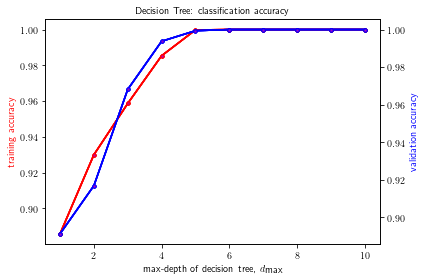

In [6]:

# Plots
print('Decision-Tree Varying Max-Depth Plot...\t')    
fig, ax1 = plt.subplots(figsize=(6, 4), tight_layout=True)
ax2 = ax1.twinx()

x_dmax = []
y_trainacc = []
y_devacc = []
for mdls in mdltrees:
    x_dmax.append(mdls['dmax'])
    y_trainacc.append(mdls['facc_train'])
    y_devacc.append(mdls['facc_dev'])

for mdls in mdltrees:
    ax1.plot(x_dmax,y_trainacc,
                color='r', marker='.', markerfacecolor='m', alpha=0.5)
    ax1.set_ylabel(f'training accuracy', color='r')
    
    ax2.plot(x_dmax,y_devacc,
                color='b', marker='.', markerfacecolor='m', alpha=0.5)
    ax2.set_ylabel(f'validation accuracy', color='b')
    ax1.set_xlabel(f"max-depth of decision tree, $d_{{\\hbox{{max}}}}$")
    ax1.set_title(f"Decision Tree: classification accuracy",
                color='k', weight='bold', size=10)
     
# plt.ion
plt.savefig(figs_dir + f"figtree_pt1.pdf", bbox_inches='tight')
print('Done.\n')


